In [27]:
# I want to import ais_test.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import daytime as dt

""" Notes:
- Check if all registered locations are in the sea
- help models with 360 degrees directions
- check for all nans
- Extracheck that port locations are congruent
- Add hasScheldue, whether the ship has a schedule or not
- Add boolean isInPort, whether the ship is in port or not
- Add daysSinceDeparture
- Add lastDepartureLatitude, lastDepartureLongitude
- Add daysUntilArrival
- Add nextArrivalLatitude, nextArrivalLongitude
- Normalize all numerical values
"""

ais_train = pd.read_csv('ais_train.csv', sep='|')
ais_train['time'] = pd.to_datetime(ais_train['time']).dt.tz_localize(None)
print(ais_train.shape)
ais_train.head(5)

(1522065, 11)


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.00,0.70,0,88,0,01-09 23:00,-34.74,-57.85,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.60,0.00,-6,347,1,12-29 20:00,8.89,-79.48,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.00,11.00,0,112,0,01-02 09:00,39.19,-76.48,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.40,0.00,0,142,1,12-31 20:00,-34.41,151.02,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.00,19.70,0,215,0,01-25 12:00,35.88,-5.92,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [28]:
# Add year to etaRaw and make it a datetime object
# If the month is august or later, make it 2023, else 2024
ais_train['etaRaw'] = pd.to_datetime('2024-' + ais_train['etaRaw'], format='%Y-%m-%d %H:%M', errors='coerce')
ais_train['etaRaw'] = ais_train['etaRaw'].apply(lambda x: x.replace(year=2023) if x.month > 7 else x)

ais_train.head(5)


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.00,0.70,0,88,0,2024-01-09 23:00:00,-34.74,-57.85,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.60,0.00,-6,347,1,2023-12-29 20:00:00,8.89,-79.48,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.00,11.00,0,112,0,2024-01-02 09:00:00,39.19,-76.48,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.40,0.00,0,142,1,2023-12-31 20:00:00,-34.41,151.02,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.00,19.70,0,215,0,2024-01-25 12:00:00,35.88,-5.92,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [29]:


# Show number, not 	1.522065e+06
pd.set_option('display.float_format', lambda x: '%.2f' % x)
ais_train.describe()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude
count,1522065,1522065.00,1522065.00,1522065.00,1522065.00,1522065.00,1518302,1522065.00,1522065.00
mean,2024-03-06 03:20:23.657231360,178.25,6.33,0.51,176.27,2.09,2024-03-05 13:55:54.755825920,36.58,11.54
min,2024-01-01 00:00:25,0.00,0.00,-127.00,0.00,0.00,2023-08-01 08:30:00,-47.53,-167.54
25%,2024-02-03 02:59:19,78.20,0.00,0.00,75.00,0.00,2024-02-02 12:00:00,34.52,-5.21
50%,2024-03-07 12:34:57,183.80,0.50,0.00,180.00,0.00,2024-03-06 23:59:00,42.23,4.23
75%,2024-04-07 07:37:36,269.00,14.10,0.00,265.00,5.00,2024-04-07 10:00:00,51.35,18.84
max,2024-05-07 23:59:08,360.00,102.30,128.00,511.00,15.00,2024-07-29 00:30:00,70.56,178.81
std,NaN,107.68,7.54,17.61,107.09,2.41,NaN,22.90,68.72


In [30]:
# 

In [31]:
schedules_to_may_2024 = pd.read_csv('schedules_to_may_2024.csv', sep='|')

schedules_to_may_2024['arrivalDate'] = pd.to_datetime(schedules_to_may_2024['arrivalDate']).dt.tz_localize(None)
schedules_to_may_2024['sailingDate'] = pd.to_datetime(schedules_to_may_2024['sailingDate']).dt.tz_localize(None)

#print(schedules_to_may_2024.shape)
#schedules_to_may_2024.head()

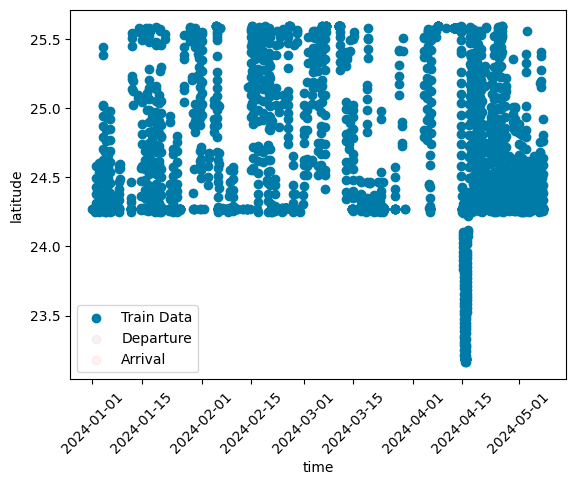

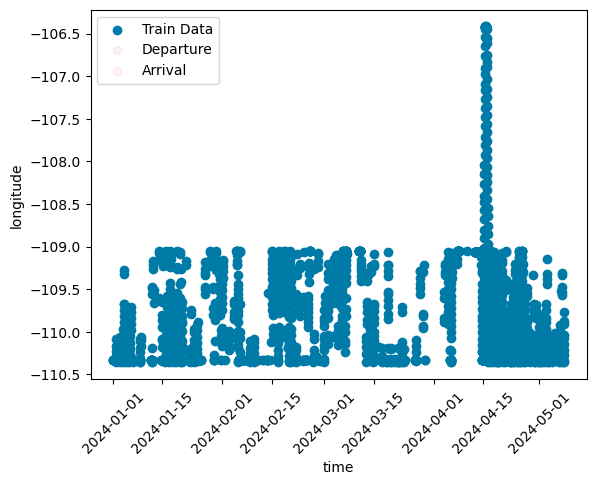

,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude


In [32]:
# Filter the same vessel entries in ais_train and ais_test
def plotVessel(vessel_id='61e9f3aeb937134a3c4bfe3d', feature='latitude'):
    train_vessel = ais_train[ais_train['vesselId'] == vessel_id]
    schedule = schedules_to_may_2024[schedules_to_may_2024['vesselId'] == vessel_id]
    # remove entries from schedule that are earlier than the first entry in ais_train
    schedule = schedule[schedule['sailingDate'] > train_vessel['time'].min()]
    # Plot latitude vs time for ais_train as a scatter plot
    plt.scatter(train_vessel['time'], train_vessel[feature], label='Train Data', color='#007BA7')
    " Plot blue dots for the depature dates and dark bliue for the arrival dates"
    plt.scatter(schedule['sailingDate'], schedule['portLatitude'], label='Departure', color='purple', alpha=0.05)
    # Semitransparent dots for the arrival dates
    plt.scatter(schedule['arrivalDate'], schedule['portLatitude'], label='Arrival', color='red', alpha=0.05)
    plt.xticks(rotation=45)
    plt.xlabel('time')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

plotVessel(vessel_id='61e9f468b937134a3c4c028f')
plotVessel(vessel_id='61e9f468b937134a3c4c028f', feature='longitude')
schedules_to_may_2024[schedules_to_may_2024['vesselId'] == '61e9f468b937134a3c4c028f'].head()
#plotVessel(feature='longitude')

In [33]:
vesselsIdsToPredict = ['61e9f468b937134a3c4c028f']#, '61e9f436b937134a3c4c0131']

vesselsToPredict = ais_train[ais_train['vesselId'].isin(vesselsIdsToPredict)]
vesselsToPredict.head()

# print unnique values for portId
print(vesselsToPredict['portId'].unique())

['61d37ac11366c3998241da0a']


## Feature Engineering

In [34]:
df = vesselsToPredict.copy()

# Print what type ais_train_FE['time'] is¨
print(type(df['time']))
df = df.sort_values('time')

df['hoursToEta'] = ((df['etaRaw'] - df['time']).dt.total_seconds() / 3600).fillna(0)
df = df.drop(columns='etaRaw')

# Added sin and cos for time of day
df['hour_sin'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)
df['minute_sin'] = np.sin(2 * np.pi * df['time'].dt.minute / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['time'].dt.minute / 60)
#df['dayOfWeek_sin'] = np.sin(2 * np.pi * df['time'].dt.dayofweek / 7) #bigger error
#df['dayOfWeek_cos'] = np.cos(2 * np.pi * df['time'].dt.dayofweek / 7) #bigger error

df.head()


<class 'pandas.core.series.Series'>


,time,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,hoursToEta,hour_sin,hour_cos,minute_sin,minute_cos
5,2024-01-01 00:05:13,186.90,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,-285.42,0.00,1.00,0.50,0.87
521,2024-01-01 01:17:15,186.90,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,-286.62,0.26,0.97,0.98,-0.21
860,2024-01-01 01:59:15,186.90,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,-287.32,0.26,0.97,-0.10,0.99
1178,2024-01-01 02:47:14,186.80,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,-288.12,0.50,0.87,-0.98,0.21
1621,2024-01-01 03:35:14,186.90,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,-288.92,0.71,0.71,-0.50,-0.87


### Feature categorisation

In [35]:
# Update these lists as new features are added
index_features = ['time', 'vesselId']
stable_features = ['hoursPassed', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']
lag_features = ['cog', 'sog', 'rot', 'heading', 'navstat', 'latitude', 'longitude', 'hoursToEta']
# Used later to separate the features
lag_features_lag = [feature + '_lag' for feature in lag_features]

## For vessel in vessels features

In [36]:

def add_features_to_vessel(df):
    df['hoursPassed'] = (df['time'].diff().dt.total_seconds() / 3600).fillna(0)

# split df into separete vessel dfs
vessel_dfs = [df[df['vesselId'] == vessel_id].copy() for vessel_id in df['vesselId'].unique()]



def add_lag_features(df, lag_features):
    for feature in lag_features:
        df.loc[:, feature + '_lag'] = df[feature].shift(1).dropna() # dropping the first row
    return df.iloc[1:].copy()

for i in range(len(vessel_dfs)):
    print(f"vessel.shape before: {vessel_dfs[i].shape}")
    vessel_dfs[i]['hoursPassed'] = (vessel_dfs[i]['time'].diff().dt.total_seconds() / 3600).fillna(0)
    vessel_dfs[i] = add_lag_features(vessel_dfs[i], lag_features)
    print(f"vessel.shape after: {vessel_dfs[i].shape}")

print(f"df.shape before: {df.shape}")
df = pd.concat(vessel_dfs)
df = df.sort_values('time')
print(f"df.shape after: {df.shape}")
df.head(5)


vessel.shape before: (2291, 15)
vessel.shape after: (2290, 24)
df.shape before: (2291, 15)
df.shape after: (2290, 24)


,time,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,...,minute_cos,hoursPassed,cog_lag,sog_lag,rot_lag,heading_lag,navstat_lag,latitude_lag,longitude_lag,hoursToEta_lag
521,2024-01-01 01:17:15,186.90,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,...,-0.21,1.20,186.90,0.00,0.00,187.00,5.00,24.27,-110.33,-285.42
860,2024-01-01 01:59:15,186.90,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,...,0.99,0.70,186.90,0.00,0.00,187.00,5.00,24.27,-110.33,-286.62
1178,2024-01-01 02:47:14,186.80,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,...,0.21,0.80,186.90,0.00,0.00,187.00,5.00,24.27,-110.33,-287.32
1621,2024-01-01 03:35:14,186.90,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,...,-0.87,0.80,186.80,0.00,0.00,187.00,5.00,24.27,-110.33,-288.12
1789,2024-01-01 04:08:14,186.80,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,...,0.67,0.55,186.90,0.00,0.00,187.00,5.00,24.27,-110.33,-288.92


## Train

#### Train on entire dataset

In [37]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare the data
X = df[index_features + lag_features_lag + stable_features]
y = df[index_features + lag_features]

split_date = pd.Timestamp('2024-04-25')
split_index = df[df['time'] < split_date].shape[0]
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

X_train = X_train.drop(columns=index_features)
y_train = y_train.drop(columns=index_features)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

print(f"y_test.columns: {y_test.columns}")


y_test.columns: Index(['time', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'navstat',
       'latitude', 'longitude', 'hoursToEta'],
      dtype='object')


##### Train on vessel only

## Predict

In [38]:
# Make a X_test_stable that only contains "lag_features" for the first row and 0 for "lag_features" for all other rows, other features are kept intact for all rowst, implement as a function
y_pred = X_test.copy()

vessel_y_preds = [y_pred[y_pred['vesselId'] == vessel_id].copy() for vessel_id in df['vesselId'].unique()]
X_test = X_test.drop(columns=index_features)
y_pred = y_pred.drop(columns=index_features)

def prepare_y_pred(X_test, lag_features_lag):
    X_test_stable = X_test.copy()
    X_test_stable[lag_features_lag] = 0.0
    X_test_stable.iloc[0, :] = X_test.iloc[0, :].copy()
    return X_test_stable

for i in range(len(vessel_y_preds)):
    vessel_y_preds[i] = vessel_y_preds[i].drop(columns=index_features)
    vessel_y_preds[i] = prepare_y_pred(vessel_y_preds[i], lag_features_lag)

# y_pred = prepare_y_pred(X_test, lag_features_lag) old non-loop

for j in range(len(vessel_y_preds)):
    # For row in y_pred, starting from row 1 (not 0), predict the next lag features and add them to y_pred
    for i in range(1, vessel_y_preds[j].shape[0]):
        prediction = model.predict(vessel_y_preds[j].iloc[i-1].values.reshape(1, -1))
        prediction = prediction.flatten()
        # Update only the lag features in the DataFrame
        vessel_y_preds[j].iloc[i, vessel_y_preds[j].columns.get_indexer(lag_features_lag)] = prediction[y_pred.columns.get_indexer(lag_features_lag)]

print(f"y_pred.shape before: {y_pred.shape}")
y_pred = pd.concat(vessel_y_preds)
#y_pred = y_pred.sort_values('time')
print(f"y_pred.shape after: {y_pred.shape}")
y_pred.head(5)


# Drop the stable features from y_pred
y_pred = y_pred.drop(columns=stable_features)
# rename lag_features to drop the _lag suffix
y_pred.columns = [feature.replace('_lag', '') for feature in y_pred.columns]
# Add the index features to y_pred from y_test.copy()
y_pred[index_features] = y_test[index_features].copy()
# make it the first column
y_pred = y_pred[index_features + lag_features]

print(f"y_test.columns: {y_test.columns}")
print(f"y_pred.columns: {y_pred.columns}")

c:\Projects\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Projects\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Projects\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Projects\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Projects\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Projects\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegressi

y_pred.shape before: (467, 13)
y_pred.shape after: (467, 13)
y_test.columns: Index(['time', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'navstat',
       'latitude', 'longitude', 'hoursToEta'],
      dtype='object')
y_pred.columns: Index(['time', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'navstat',
       'latitude', 'longitude', 'hoursToEta'],
      dtype='object')


c:\Projects\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Projects\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Projects\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Projects\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Projects\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Projects\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegressi

## Evaluate

Index(['time', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'navstat',
       'latitude', 'longitude', 'hoursToEta'],
      dtype='object')
Index(['time', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'navstat',
       'latitude', 'longitude', 'hoursToEta'],
      dtype='object')


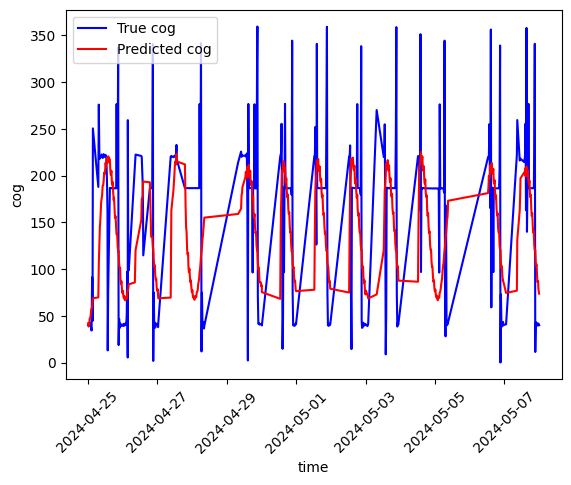

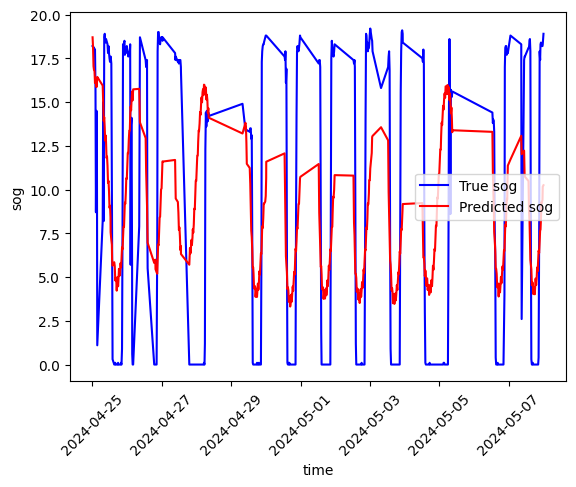

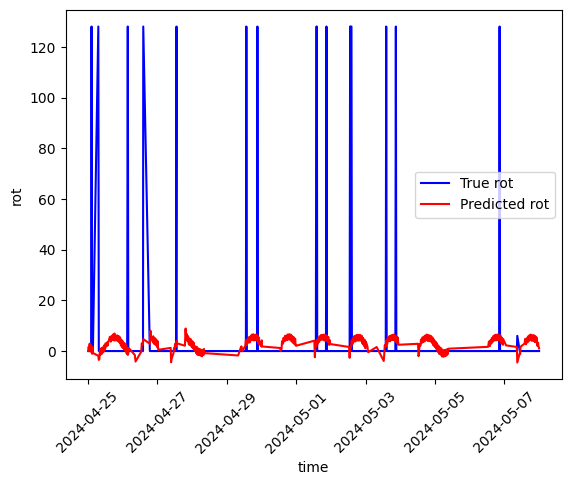

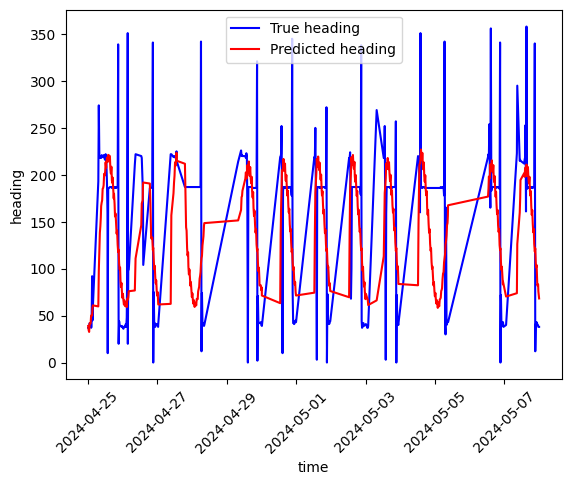

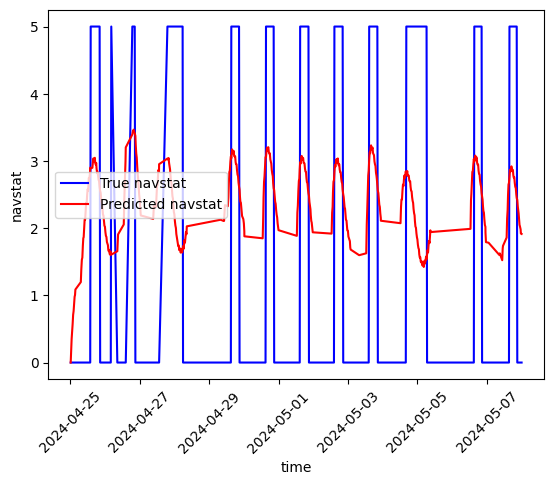

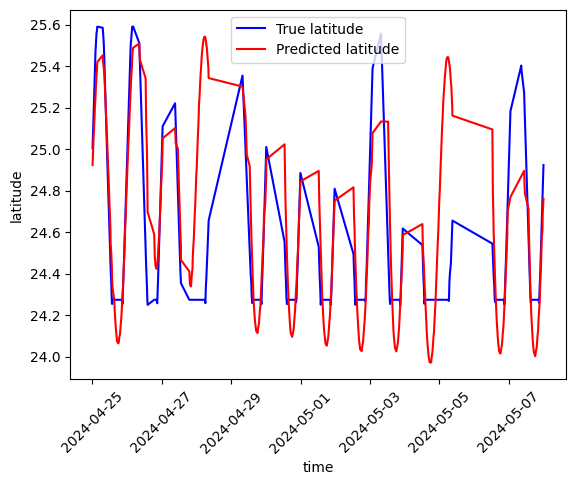

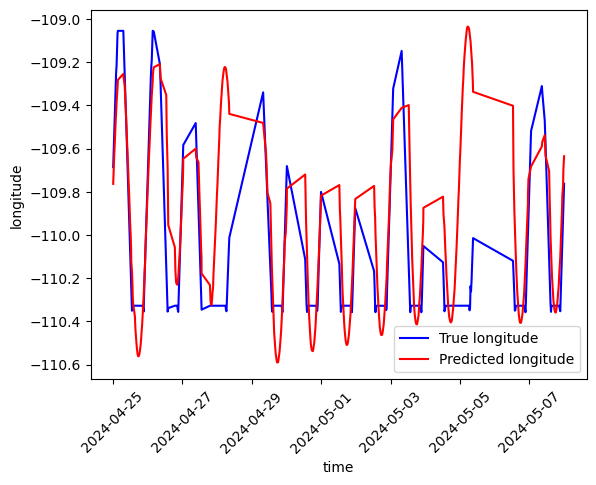

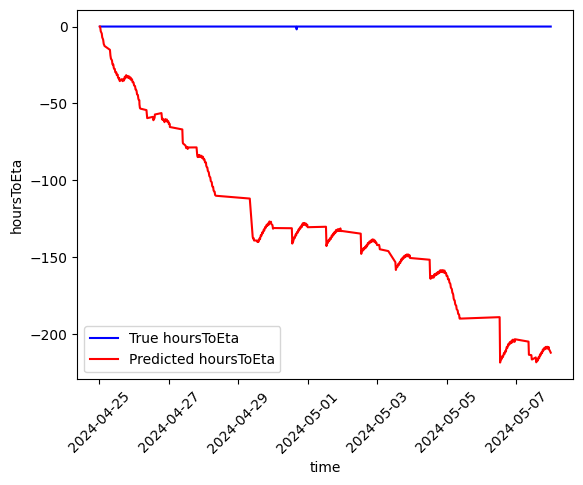

In [39]:
print(y_pred.columns)
print(y_test.columns)

for vessel_id in y_pred['vesselId'].unique():
    for feature in lag_features:
        plt.plot(y_test[y_test['vesselId'] == vessel_id]['time'], y_test[y_test['vesselId'] == vessel_id][feature], label=f'True {feature}', color='blue')
        plt.plot(y_pred[y_pred['vesselId'] == vessel_id]['time'], y_pred[y_pred['vesselId'] == vessel_id][feature], label=f'Predicted {feature}', color='red')
        plt.xticks(rotation=45)
        plt.xlabel('time')
        plt.ylabel(feature)
        plt.legend()
        plt.show()


In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Drop the time column from y_test and y_pred
y_test_values = y_test.drop(columns='time')
y_pred_values = y_pred.drop(columns='time')

# Calculate Mean Absolute Error (MAE) for latitude and longitude
mae = mean_absolute_error(y_test_values[['latitude', 'longitude']], y_pred_values[['latitude', 'longitude']])
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_values[['latitude', 'longitude']], y_pred_values[['latitude', 'longitude']])
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')



"""
First true result:
Mean Absolute Error (MAE): 144.74297616461251
Mean Squared Error (MSE): 153729.17231131133
Root Mean Squared Error (RMSE): 392.08311913586806


Addad cos and sin hour and minutes:
Mean Absolute Error (MAE): 32.24486859767559
Mean Squared Error (MSE): 3933.24368943852
Root Mean Squared Error (RMSE): 62.71557772546244

Changed to lat and long only:
Mean Absolute Error (MAE): 0.2509074275080679
Mean Squared Error (MSE): 0.15327578600297276
Root Mean Squared Error (RMSE): 0.3915045159419911

Added week, bigger error:
Mean Absolute Error (MAE): 0.2824689055554052
Mean Squared Error (MSE): 0.1859583316950395
Root Mean Squared Error (RMSE): 0.4312288623167975




"""

Mean Absolute Error (MAE): 0.2509074275080679
Mean Squared Error (MSE): 0.15327578600297276
Root Mean Squared Error (RMSE): 0.3915045159419911


'\nFirst true result:\nMean Absolute Error (MAE): 144.74297616461251\nMean Squared Error (MSE): 153729.17231131133\nRoot Mean Squared Error (RMSE): 392.08311913586806\n\n\nAddad cos and sin hour and minutes:\nMean Absolute Error (MAE): 32.24486859767559\nMean Squared Error (MSE): 3933.24368943852\nRoot Mean Squared Error (RMSE): 62.71557772546244\n\nChanged to lat and long only:\nMean Absolute Error (MAE): 0.2509074275080679\nMean Squared Error (MSE): 0.15327578600297276\nRoot Mean Squared Error (RMSE): 0.3915045159419911\n\nAdded week, bigger error:\nMean Absolute Error (MAE): 0.2824689055554052\nMean Squared Error (MSE): 0.1859583316950395\nRoot Mean Squared Error (RMSE): 0.4312288623167975\n\n\n\n\n'